In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (6, 4)

# ignore pandas warnings
import warnings
warnings.simplefilter('ignore')

import time
start = time.time()

In [2]:
# load data
data = pd.read_csv('training_ultrasound.csv')

# remove agedays > 0 ( we just only focus pre-birth measurements)
data = data[data['AGEDAYS']<0]

# drop rows with missing data in any of the 5 main columns
ultrasound = ['HCIRCM', 'ABCIRCM', 'BPDCM', 'FEMURCM']
target = 'BWT_40'
data.dropna(subset=ultrasound+[target], inplace=True)

# correct faulty data
data.loc[data['STUDYID']==2, 'PARITY'] = data.loc[data['STUDYID']==2, 'PARITY'] + 1

## Model

In [3]:
# select basic vars
df = data[ultrasound + ['GAGEDAYS', 'SEXN', 'PARITY', 'GRAVIDA'] + [target]]

In [4]:
df.isnull().sum()

HCIRCM        0
ABCIRCM       0
BPDCM         0
FEMURCM       0
GAGEDAYS      0
SEXN          0
PARITY      101
GRAVIDA     101
BWT_40        0
dtype: int64

In [5]:
# there is missing data for parity and gravida: this happens for first pregnancy --> fill with 1s
df.fillna(1, inplace=True)

# replace sex values to 0 and 1
df['SEXN'] = df['SEXN'].replace([1,2], [0,1])

### Feature engineering 

In [6]:
# aspect ratio: measure of the slenderness
df['femur/abd'] = df['FEMURCM']/df['ABCIRCM']

# excentricity of the cenithal snapshot of the head (similar to ellipse)
df['head'] = df['HCIRCM'] / df['BPDCM']

# proxy for head volume
df['vol'] = (df['BPDCM'])**3

# body as a cilinder of radius ABCIRCM and height FEMURCM
df['cilinder'] =(df['ABCIRCM']**2)*df['FEMURCM']

# full interaction term for the 4 measurements
df['four'] = df['HCIRCM']*df['BPDCM']*df['ABCIRCM']*df['FEMURCM']

# femur length scaled with time
df['femur_temp'] = (df['FEMURCM']/df['GAGEDAYS'])

# head-femur polynomial interaction term
df['head*femur'] = df['head']*df['FEMURCM']

# no of past pregancies
df['past_gest'] = df['PARITY'] - df['GRAVIDA']

In [7]:
# common models for sonographic fetal weight estimation use log of the weight
df['BWT_40'] = np.log(1 + df['BWT_40'])

In [8]:
print('Dataframe size: %s,%s' % (df.shape[0],df.shape[1]))

Dataframe size: 7928,17


In [9]:
# sklearn imports
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LassoCV, Lasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error

from aux_fun import plot_learning_curve, plot_validation_curve

### Split train/test data

In [10]:
# df to np arrays
X = df.drop(target,axis=1).values

Y = df[target].values

# train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

### Define model pipeline

In [11]:
pl = make_pipeline(StandardScaler(),SelectFromModel(LassoCV(n_jobs=-1,random_state=0)),Ridge())

#### CV strategy

In [12]:
kf = KFold(n_splits=5,random_state=0)

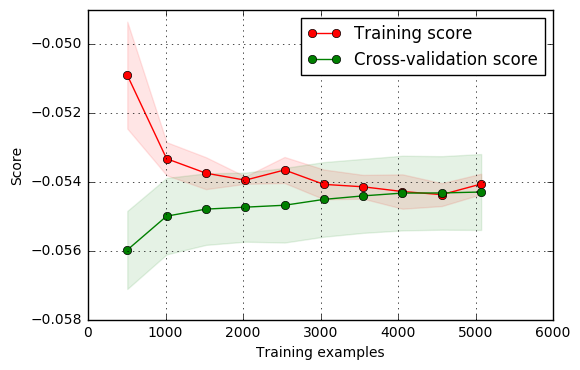

In [13]:
plot_learning_curve(pl,'',x_train,y_train,n_jobs=-1,scoring='mean_absolute_error',cv=kf, train_sizes=np.linspace(.1, 1.0, 10));

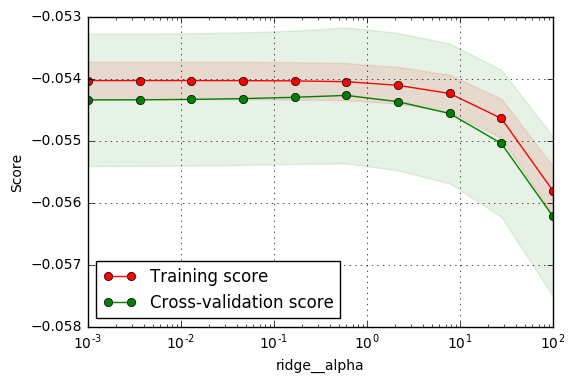

In [14]:
plot_validation_curve(pl,'',x_train,y_train,n_jobs=-1,scoring='mean_absolute_error',
                     param_name='ridge__alpha',param_range=np.logspace(-3, 2, 10),cv=kf);

In [15]:
scores = list()
pl.set_params(ridge__alpha=0.5)
for train_k, test_k in kf.split(x_train):
    pl.fit(x_train[train_k],y_train[train_k])
    scores.append(mean_absolute_error(y_train[test_k], pl.predict(x_train[test_k])))
print('Score: %0.4f +- %0.4f' % (np.mean(scores),2*np.std(scores)))

Score: 0.0543 +- 0.0022


#### Fit whole train with best hyperparameter

In [16]:
pl.fit(x_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectfrommodel', SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=-1, normalize=False,
    positive=False, precompute='au...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

#### Feature importances

In [17]:
coef_df = pd.DataFrame({'feature':df.drop(target,axis=1).columns[pl.steps[1][1].get_support()],
                        'weight':pl.steps[2][1].coef_})
coef_df['abs_weight'] = np.abs(coef_df['weight'])
sort_coef_df = coef_df.sort_values(by='abs_weight',ascending=False).drop('abs_weight',axis=1)

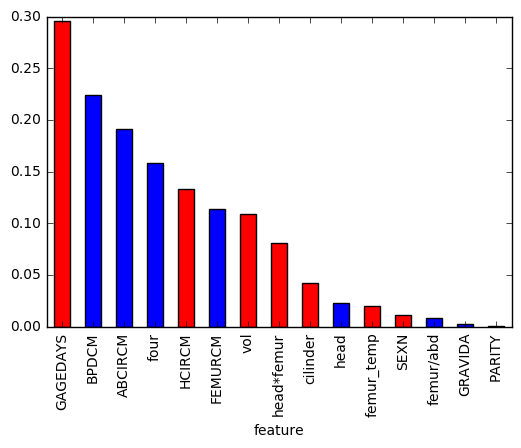

In [18]:
colors = sort_coef_df['weight'].apply(lambda x: 'b' if x>0 else 'r').tolist()
np.abs(sort_coef_df.set_index('feature',drop=True)).plot(kind='bar',color=colors,legend=False);

## Model assessment

In [19]:
# Compute true errors
w_true = np.exp(y_test) - 1
w_pred = np.exp(pl.predict(x_test)) - 1
abs_error = np.absolute(w_true - w_pred)
mean_abs_error = abs_error.mean()
pct_error = abs_error / w_true

# true test set errors
print('Mean absolute error: %0.4f' % mean_abs_error)
print('Mean relative error: %0.4f' % pct_error.mean())

Mean absolute error: 0.2254
Mean relative error: 0.0691


In [20]:
time.time() - start

11.403384923934937